In [42]:
# Importing Libraries
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve

## About this dataset

### Stuff we know:

* Age : Age of the patient

* Sex : Sex of the patient

* exng: exercise induced angina (1 = yes; 0 = no)

* caa: number of major vessels (0-3)

* cp : Chest Pain type chest pain type

    * Value 1: typical angina
    * Value 2: atypical angina
    * Value 3: non-anginal pain
    * Value 4: asymptomatic

* trtbps : resting blood pressure (in mm Hg)

* chol : cholestoral in mg/dl fetched via BMI sensor

* fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

* restecg : resting electrocardiographic results

    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* thalach : maximum heart rate achieved

### Stuff we should predict
* target : 
    * 0 = less chance of heart attack 
    * 1 = more chance of heart attack

In [43]:
# Importing Data
data = pd.read_csv('../input/heart-attack-analysis-prediction-dataset/heart.csv')

# Printing Data Info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


<AxesSubplot:>

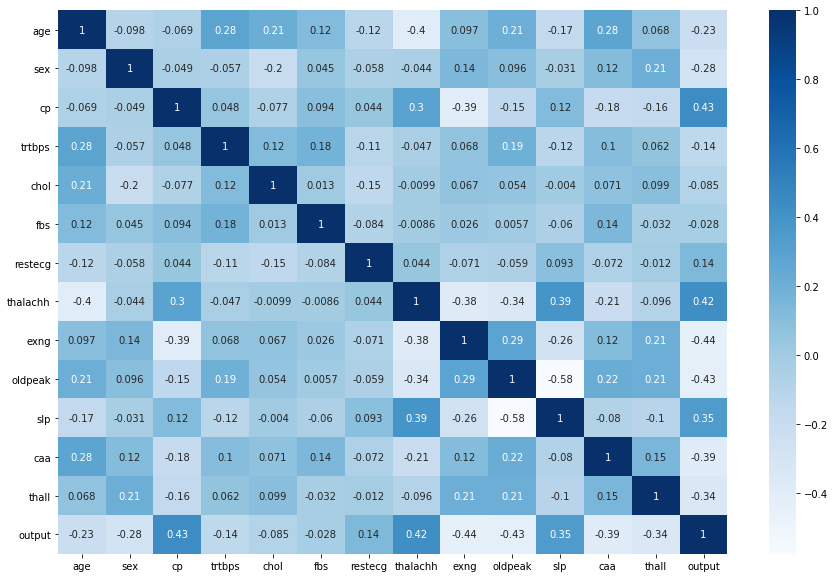

In [44]:
# Co-relation Matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), cmap='Blues', annot=True, ax=ax)

## Feature Engineering

In [45]:
# Since 'caa', 'cp', 'restecg' are categories rather than just integers
# We divide them into categories
dummies = pd.get_dummies(pd.DataFrame(data[['caa', 'cp', 'restecg']], dtype='object'))
dummies.head()

,caa_0,caa_1,caa_2,caa_3,caa_4,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,1,0,0,0,0,0,0,0,1,1,0,0
1,1,0,0,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,1,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,1,0,0,0,0,1,0


In [46]:
# Considering all the features except 'caa', 'cp', and 'restecg'
features = ['age', 'sex', 'trtbps','thalachh', 'exng', 'oldpeak', 'slp', 'thall', 'output']
data = data[features]
data.head()

,age,sex,trtbps,thalachh,exng,oldpeak,slp,thall,output
0,63,1,145,150,0,2.3,0,1,1
1,37,1,130,187,0,3.5,0,2,1
2,41,0,130,172,0,1.4,2,2,1
3,56,1,120,178,0,0.8,2,2,1
4,57,0,120,163,1,0.6,2,2,1


In [47]:
# Joining Number Data with the Categorical Data
data = pd.concat([data, dummies], axis=1)
data.head()

,age,sex,trtbps,thalachh,exng,oldpeak,slp,thall,output,caa_0,...,caa_2,caa_3,caa_4,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,150,0,2.3,0,1,1,1,...,0,0,0,0,0,0,1,1,0,0
1,37,1,130,187,0,3.5,0,2,1,1,...,0,0,0,0,0,1,0,0,1,0
2,41,0,130,172,0,1.4,2,2,1,1,...,0,0,0,0,1,0,0,1,0,0
3,56,1,120,178,0,0.8,2,2,1,1,...,0,0,0,0,1,0,0,0,1,0
4,57,0,120,163,1,0.6,2,2,1,1,...,0,0,0,1,0,0,0,0,1,0


## Data Handling

In [48]:
# We can observe outliers on 'oldpeak' column. 
# Outliers must be handled to avoid disruption in prediction accuracy.
def outliers(dataCol):
    # sorting column
    sorted(dataCol)
    
    # Interquartile Range
    Q1,Q3 = np.percentile(dataCol,[25,75])    
    IQR = Q3-Q1
    
    # Lower Range Error
    LowerRange = Q1-(1.5 * IQR)
    
    # Upper Range Error
    UpperRange = Q3+(1.5 * IQR)
    
    return LowerRange,UpperRange

<AxesSubplot:xlabel='oldpeak'>

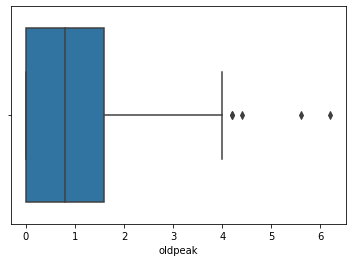

In [49]:
# Outliers in OldPeak, Denoted by dots
sns.boxplot(data=data, x='oldpeak')

In [50]:
# We get the limits of the column
lwoldpeak,upoldpeak = outliers(data['oldpeak'])

# Limiting the column values between lwoldpeak and upoldpeak
data['oldpeak'].replace(list(data[data['oldpeak'] < lwoldpeak].oldpeak) ,lwoldpeak,inplace=True)
data['oldpeak'].replace(list(data[data['oldpeak'] > upoldpeak].oldpeak) ,upoldpeak,inplace=True)

<AxesSubplot:xlabel='oldpeak'>

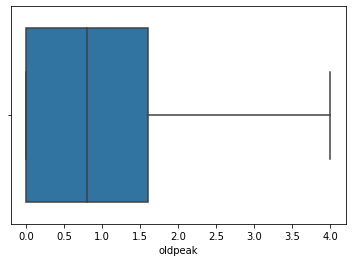

In [51]:
# Outliers Managed 
sns.boxplot(data=data, x='oldpeak')

In [52]:
# Splitting Data into Postive and Negative Heart Attack cases.
# The dataset has 'output'= 1 for all the top rows and 'output'= 0 for bottom rows

data_1 = data[data['output']==0]
data_2 = data[data['output']==1]
data_1.shape, data_2.shape

((138, 21), (165, 21))

## Training and Testing Dataset Spilt

In [53]:
# Adding rows from both the true and false predictions with good 1:0 split 
train_data = pd.concat([data_1.iloc[:125,:], data_2.iloc[:152, :]], ignore_index=True)
test_data = pd.concat([data_1.iloc[125:,:], data_2.iloc[152:, :]], ignore_index=True)

train_data.shape, test_data.shape

((277, 21), (26, 21))

In [54]:
# Shuffling the data to mix up the features
train_data = shuffle(train_data)
test_data = shuffle(test_data)

<AxesSubplot:xlabel='output', ylabel='count'>

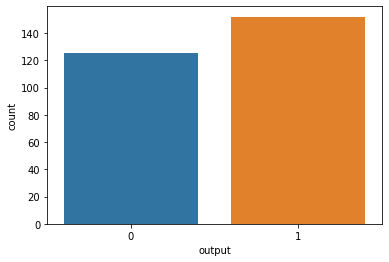

In [55]:
sns.countplot(data = train_data, x='output')

<AxesSubplot:xlabel='output', ylabel='count'>

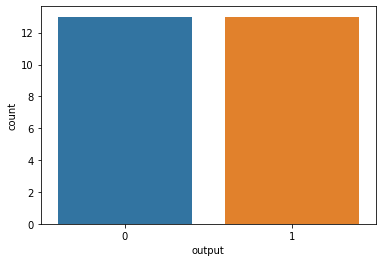

In [56]:
sns.countplot(data = test_data, x='output')

In [57]:
# Splitting Labels into Training and Validation
train_labels = np.array(train_data['output'])
test_labels = np.array(test_data['output'])

In [58]:
# Splitting Data into Training and Validation
train_features = np.array(train_data.iloc[:, :-1])
test_features = np.array(test_data.iloc[:, :-1])

In [59]:
# Printing out data shapes
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((277, 20), (277,), (26, 20), (26,))

## Model Development

In [60]:
def initialize_weights(shape, dtype=None):
    
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
    
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def DeepLearningModel(input_shape):
    model = Sequential()
    
    model.add(Input(input_shape))
    
    model.add(Dense(16, activation='relu', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    
    model.add(Dense(32, activation='relu', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    
    model.add(Dense(64, activation='relu', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))    
    
    return model

In [61]:
# Hyperparameters

# These hyperparameters can be modified to get different output.
# I found these to work well for the data. Play around and let me know in comments

model = DeepLearningModel((20))
print(model.summary())
lr = 0.003
epochs = 40
batch_size = 100
optimizer = Adam(lr)

# You can try different Keras Error for Different Prediction Values.
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 3,057
Trainable params: 3,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
3/3 [==============================] - 1s 3ms/step - loss: 0.7009 - accuracy: 0.5394
Epoch 2/40
3/3 [==============================] - 0s 2ms/step - loss: 0.6864 - accuracy: 0.5594
Epoch 3/40
3/3 [==============================] - 0s 

## Plotting Performance over Training Set

<AxesSubplot:>

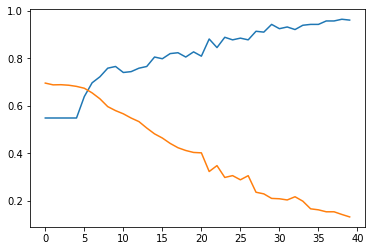

In [62]:
# Plotting Accuracy and Loss against Number of Epochs
sns.lineplot(x=history.epoch, y=history.history['accuracy'])
sns.lineplot(x=history.epoch, y=history.history['loss'])

## Model Evaluation using Test Dataset

In [63]:
# Evaluating on Validation Dataset
model.evaluate(test_features, test_labels)

1/1 [==============================] - 0s 145ms/step - loss: 0.1342 - accuracy: 0.9615


[0.13415168225765228, 0.9615384340286255]

## Confusion Matrix for Test Dataset

<AxesSubplot:>

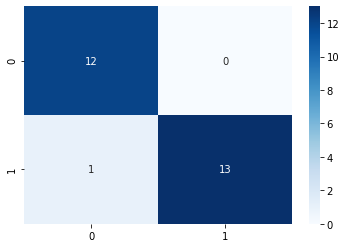

In [64]:
# Plotting Confusion Matrix for better understanding of Model Performance on Validation
roc_act = test_labels
roc_pred = list(map(int, np.round(model.predict(test_features))))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(roc_pred, roc_act), cmap='Blues', annot=True, fmt='')

## 96% Test Accuracy using DNN Model for Heart Attack Prediction.